# Measuring representational distance between corners, corners with objects and task related cells activation. 

Here we measure the euclidena distance in the mean represetantion of corners, corners with objects and the task after applying differennt transformations to the cells data (dimensionality reduction)

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA



import warnings
warnings.filterwarnings("ignore")
from analysis_functions import *


In [2]:
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
binary = True

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
period = int(10 * sf / re_sf)
period_resting = period *50
N_SHUFFLINGS = 50
colorcodes = ['Greys','PuBu', 'YlOrRd','Reds','Blues','Oranges','Greens']


In [13]:
mouse = 401714  ### mouse number id
for session_now in range(2,3):
    print('SESSION ================================================================================================', session_now)
    task,colapse_behaviour,object_fixed,fixed,labels,colornames = mouse_properties(mouse = mouse, session_now = session_now)
    file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
    timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
    behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
    behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
    tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
    objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
    figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/trial_aligned_events/'

    print('++++++++++++++++++++++++DAY WISE++++++++++++++++++++++++++++++++++')
    print('CREATING ACTIVITY LIST')
    activity_list,timeline_list,behaviour_list,corners_list,parameters_time,parameters_list,parameters_list2, speed_list, day_list,tracking_list= load_data(mouse, session_now,decoding_v, motion_correction_v, alignment_v, equalization_v,source_extraction_v,component_evaluation_v, re_sf,file_directory, timeline_file_dir, behaviour_dir, behaviour_dir_parameters, tracking_dir, objects_dir,binary = binary)
    print('APPLYING MULTIPLE DATA TRANSFORAMTION')
    data_transformation = transform_neural_data(activity_list, behaviour_list,parameters_time,parameters_list,parameters_list2,timeline_list,day_list)    
    print('CREATE TASK VECTOR')
    create_task_behaviour(behaviour_list,colapse_behaviour,object_fixed,timeline_list,day_list)
    print('CREATING CORNERS VECTORS VECTORS')
    navigation_list, exploration_list = create_corners_occupation(behaviour_list, corners_list, speed_list,day_list)
    print('ETHOGRAM DISTANCE DAYWISE')

    id_target_etho = [3,4]
    trial_activity_etho, trial_activity_shuffle_etho, distance_etho = compute_representational_distance_measures(activity_list,data_transformation,period,behaviour_list,id_target_etho,N_SHUFFLINGS,day_list)
    save_distance(mouse,session_now,distance_etho,'task',day_list)
    print('NAVIGATION DISTANCE TRIAL DAYWISE')
    id_target_corners = [1,2,3,4]
    trial_activity_etho, trial_activity_shuffle_etho, distance_nav = compute_representational_distance_measures(activity_list,data_transformation,period,navigation_list,id_target_corners,N_SHUFFLINGS,day_list)
    save_distance(mouse,session_now,distance_nav,'nav',day_list)
    print('EXPLORATION DISTANCE TRIAL DAYWISE')
    id_target_exp = [1,2,3,4]
    trial_activity_etho, trial_activity_shuffle_etho, distance_exp = compute_representational_distance_measures(activity_list,data_transformation,period,navigation_list,id_target_exp,N_SHUFFLINGS,day_list)
    save_distance(mouse,session_now,distance_exp,'exp',day_list)
    
    print('++++++++++++++++++++++++TRIAL WISE ++++++++++++++++++++++++++++++++++')
    
    activity_list_trial,timeline_list_trial,behaviour_list_trial,corners_list_trial,parameters_time_trial,parameters_list_trial,parameters_list2_trial, speed_list_trial,trial_list,tracking_list_trial = load_data_trial(mouse, session_now,decoding_v, motion_correction_v, alignment_v, equalization_v,source_extraction_v,component_evaluation_v, re_sf,file_directory, timeline_file_dir, behaviour_dir, behaviour_dir_parameters, tracking_dir, objects_dir,binary = binary)    
    data_transformation_trial = transform_neural_data(activity_list_trial, behaviour_list_trial,parameters_time_trial,parameters_list_trial,parameters_list2_trial,timeline_list_trial,trial_list)
    create_task_behaviour_trial(behaviour_list_trial,colapse_behaviour,object_fixed,timeline_list_trial,trial_list)
    navigation_list_trial, exploration_list_trial = create_corners_occupation(behaviour_list_trial, corners_list_trial, speed_list_trial,trial_list)

    print('ETHOGRAM DISTANCE TRIAL TRIALWISE')
    id_target_etho = [3,4]
    trial_activity_etho, trial_activity_shuffle_etho, distance_etho_trial = compute_representational_distance_measures(activity_list_trial,data_transformation_trial,period,behaviour_list_trial,id_target_etho,N_SHUFFLINGS,trial_list)
    save_distance(mouse,session_now,distance_etho_trial,'task',trial_list,day_flag = False)
    print('NAVIGATION DISTANCE TRIAL DAYWISE')
    id_target_corners = [1,2,3,4]
    trial_activity_etho, trial_activity_shuffle_etho, distance_nav_trial = compute_representational_distance_measures(activity_list_trial,data_transformation_trial,period,navigation_list_trial,id_target_corners,N_SHUFFLINGS,trial_list)
    save_distance(mouse,session_now,distance_nav_trial,'nav',trial_list,day_flag = False)
    print('EXPLORATION DISTANCE TRIAL DAYWISE')
    id_target_exp = [1,2,3,4]
    trial_activity_etho, trial_activity_shuffle_etho, distance_exp_trial = compute_representational_distance_measures(activity_list_trial,data_transformation_trial,period,exploration_list_trial,id_target_exp,N_SHUFFLINGS,trial_list)
    save_distance(mouse,session_now,distance_exp_trial,'exp',trial_list,day_flag = False)
    
    print("DONE")

SESSION ================================================================================================ 2
++++++++++++++++++++++++DAY WISE++++++++++++++++++++++++++++++++++
CREATING ACTIVITY LIST
LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR
neural shape =  (201, 38453) beh shape(38453,)
neural shape =  (114, 38349) beh shape(38349,)
APPLYING MULTIPLE DATA TRANSFORAMTION
CREATE TASK VECTOR
REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS
CREATING CORNERS VECTORS VECTORS
ETHOGRAM DISTANCE DAYWISE
CREATE LIST THAT SAVES ALL THE EVENTS IN A DAY AND CONTAINS ONSET OF VISITS
NOW WE SEPARATE EVENTS TYPES ACCORDING TO CORNER/OBJECT VISIT
BALANCING TO THE LOWER NUMBER OF VISITS
CREATE SHUFFLE LABELS THAT PRESERVE BALANCE
TAKING NEURAL OR TRANSFORMED ACTIVITY FOR EACH EVENT ... and create list with that
CREATING VISITIS ACTIVITY MATRICES
CREATING DISTANCE tuple
Saving
Saving
Saving
Saving
NAVIGATION DISTANCE TRIAL DAYWISE
CREATE LIST THAT SAVES ALL THE EVENTS IN A DA

In [5]:
activity_list[0].shape

(46, 35508)

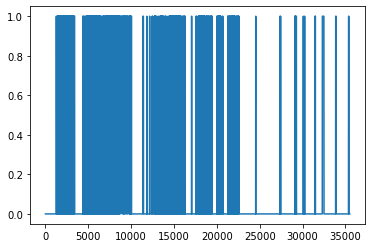

In [12]:
plt.plot(activity_list[0][40,:])

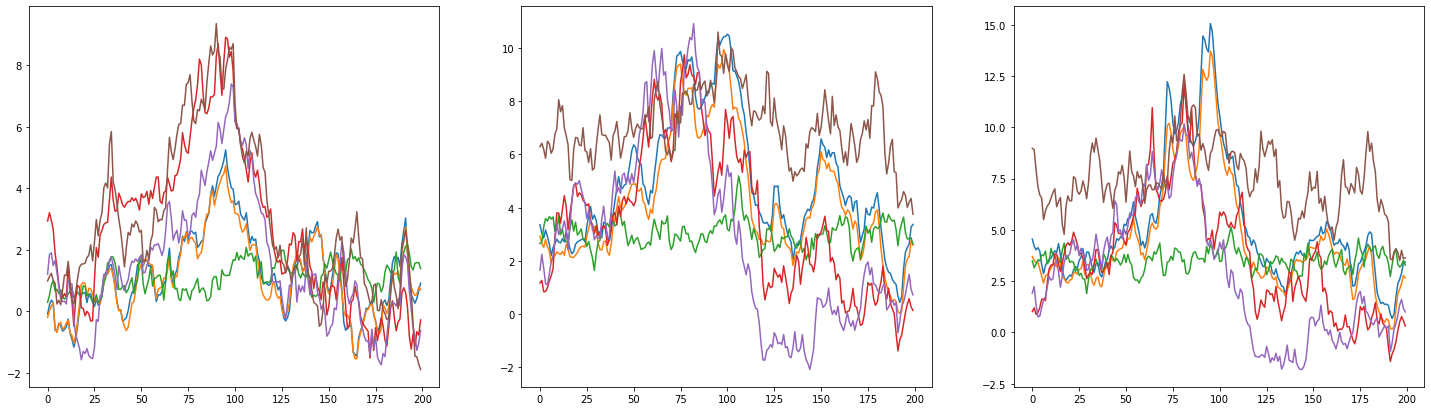

In [4]:
figure, axes = plt.subplots(1,3)

axes[0].plot(distance_etho.neural[0])
axes[0].plot(distance_etho.pca[0])
axes[0].plot(distance_etho.cca_time[0])
axes[0].plot(distance_etho.cca_allo[0])
axes[0].plot(distance_etho.cca_ego[0])
axes[0].plot(distance_etho.lda[0])

axes[1].plot(distance_nav.neural[0])
axes[1].plot(distance_nav.pca[0])
axes[1].plot(distance_nav.cca_time[0])
axes[1].plot(distance_nav.cca_allo[0])
axes[1].plot(distance_nav.cca_ego[0])
axes[1].plot(distance_nav.lda[0])

axes[2].plot(distance_exp.neural[0])
axes[2].plot(distance_exp.pca[0])
axes[2].plot(distance_exp.cca_time[0])
axes[2].plot(distance_exp.cca_allo[0])
axes[2].plot(distance_exp.cca_ego[0])
axes[2].plot(distance_exp.lda[0])

figure.set_size_inches([25,7])
figure.savefig(figure_path + 'mouse_' + f'{mouse}' + '_session_' + f'{session_now}' + '.png' )

4

##### 

6

6